In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [3]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

And finally, differential operators that allow us to leverage autograd to compute gradients, the laplacian, etc.

In [14]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)

def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
def get_cameraman_tensor(sidelength):
    img = Image.fromarray(skimage.data.camera())
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img



def get_meerkat_image(sidelength):
  from astropy.io import fits
  import numpy as np
  filename = "/content/drive/MyDrive/Colab Notebooks/MeerKAT_Galactic_Centre_1284MHz-StokesI.fits"
  with fits.open(filename) as hdul:
      data = hdul[0].data[4500:4500+sidelength,4500:4500+sidelength].astype(np.float32)
  data = data-np.min(data)
  data+=1e-5
  data=np.log(data)
  data = data-np.min(data)
  data = data/np.max(data)
  img =  Image.fromarray(data)
  del data
  transform = Compose([
      Resize(sidelength),
      ToTensor(),
      Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
  ])
  img = transform(img)
  return img

In [7]:
class ImageFitting(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        #img = get_cameraman_tensor(sidelength)
        img = get_meerkat_image(sidelength)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0: raise IndexError

        return self.coords, self.pixels


In [37]:
cameraman = ImageFitting(256)
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=1, hidden_features=256,
                  hidden_layers=3, outermost_linear=True)
img_siren.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

We now fit Siren in a simple training loop. Within only hundreds of iterations, the image and its gradients are approximated well.

In [38]:
total_steps = 500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 20

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

model_input_full, ground_truth_full = next(iter(dataloader))
model_input_full, ground_truth_full = model_input_full.cuda(), ground_truth_full.cuda()

# Determine the sidelength for visualization dynamically
sidelength_val = int(np.sqrt(model_input_full.shape[1]))

# Define batch size for processing during training loop
# Process in smaller batches to avoid OutOfMemoryError
batch_size_pixels = 2048 # Experiment with this value based on GPU memory. Adjust if still OOM.
num_pixels = model_input_full.shape[1]
num_batches = (num_pixels + batch_size_pixels - 1) // batch_size_pixels # Ceiling division

for step in range(total_steps):
    optim.zero_grad() # Zero gradients for the entire image pass

    current_loss = 0.0

    # Iterate over mini-batches of pixels
    for i in range(num_batches):
        start_idx = i * batch_size_pixels
        end_idx = min((i + 1) * batch_size_pixels, num_pixels)

        # Extract batch of coordinates and ground truth
        batch_model_input  = model_input_full[ :, start_idx:end_idx, :]
        batch_ground_truth = ground_truth_full[:, start_idx:end_idx, :]

        # Forward pass for the current batch
        # `coords` returned by img_siren is just `batch_model_input` cloned with requires_grad=True
        model_output_batch, _ = img_siren(batch_model_input)

        # Calculate loss for the current batch
        loss = ((model_output_batch - batch_ground_truth)**2).mean()

        # Accumulate gradients (loss.backward() adds to existing gradients)
        loss.backward() # Gradients are accumulated across batches before a single optim.step()

        current_loss += loss.item() * (end_idx - start_idx) # Accumulate weighted loss for overall average

    optim.step() # Update model parameters using accumulated gradients
    current_loss /= num_pixels # Average loss over all pixels processed in this step

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, current_loss))


Step 0, Total loss 0.120377
Step 20, Total loss 0.003186
Step 40, Total loss 0.001927
Step 60, Total loss 0.001659
Step 80, Total loss 0.001568
Step 100, Total loss 0.001516
Step 120, Total loss 0.001479
Step 140, Total loss 0.001451
Step 160, Total loss 0.001427
Step 180, Total loss 0.001405
Step 200, Total loss 0.001384
Step 220, Total loss 0.001364
Step 240, Total loss 0.001343
Step 260, Total loss 0.001322
Step 280, Total loss 0.001300
Step 300, Total loss 0.001275
Step 320, Total loss 0.001248
Step 340, Total loss 0.001219
Step 360, Total loss 0.001187
Step 380, Total loss 0.001151
Step 400, Total loss 0.001110
Step 420, Total loss 0.001066
Step 440, Total loss 0.001016
Step 460, Total loss 0.000961
Step 480, Total loss 0.000902


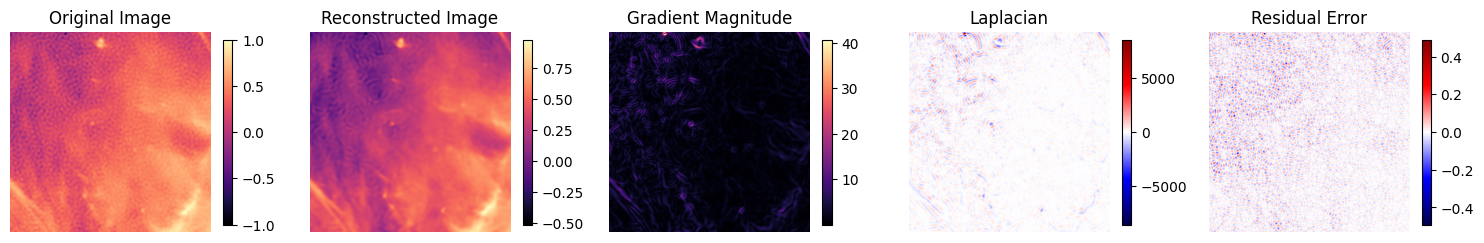

In [ ]:
# Visualization after training
import matplotlib.colors as colors

# Initialize tensors to store the full reconstructed image, gradients, and Laplacian
full_model_output   = torch.empty_like(ground_truth_full)
full_grad_output    = torch.zeros(ground_truth_full.shape[0], ground_truth_full.shape[1], 2, device=ground_truth_full.device)
full_laplace_output = torch.empty_like(ground_truth_full)

# Define a smaller batch size for gradient/laplacian visualization to prevent OOM
batch_size_pixels_viz = 2048 # Reduced batch size for visualization of gradients/laplacian
num_batches_viz = (num_pixels + batch_size_pixels_viz - 1) // batch_size_pixels_viz

# Process the full image in batches for visualization
for i in range(num_batches_viz):
    start_idx_viz = i * batch_size_pixels_viz
    end_idx_viz = min((i + 1) * batch_size_pixels_viz, num_pixels)

    # Siren's forward method internally creates a tensor with requires_grad=True
    # We need to capture this internal tensor for calculating gradients and Laplacian.
    batch_model_input_coords = model_input_full[:, start_idx_viz:end_idx_viz, :]
    batch_output, coords_for_grad = img_siren(batch_model_input_coords) # Get the internal coords from Siren

    # Calculate gradients and Laplacian
    img_grad = gradient(batch_output, coords_for_grad) # Use coords_for_grad for gradient calculation
    img_laplacian = laplace(batch_output, coords_for_grad) # Use coords_for_grad for laplace calculation

    # Store results in the full tensors
    full_model_output[  :, start_idx_viz:end_idx_viz, :] = batch_output.detach()
    full_grad_output[   :, start_idx_viz:end_idx_viz, :] = img_grad.detach()
    full_laplace_output[:, start_idx_viz:end_idx_viz, :] = img_laplacian.detach()

# Plot the results
fig, axes = plt.subplots(1,5, figsize=(15,4)) # Adjusted figsize for better viewing

# Shared colour scale for original & reconstructed
vmin = ground_truth_full.min().item()
vmax = ground_truth_full.max().item()

# Original Image
c0 = axes[0].imshow(
    ground_truth_full.cpu().view(sidelength_val, sidelength_val).detach().numpy(),
    cmap='magma',
    vmin=vmin,
    vmax=vmax
)
axes[0].set_title("Original Image")
axes[0].axis('off') # Hide axes for cleaner image display


# Reconstructed Image
c1 = axes[1].imshow(
    full_model_output.cpu().view(sidelength_val, sidelength_val).detach().numpy(),
    cmap='magma',
    vmin=vmin,
    vmax=vmax
)
axes[1].set_title("Reconstructed Image")
axes[1].axis('off') # Hide axes for cleaner image display

# Gradient Magnitude
# Normalize gradient magnitude for better visualization, if needed
grad_magnitude = full_grad_output.norm(dim=-1).cpu().view(sidelength_val, sidelength_val).detach().numpy()
c2 = axes[2].imshow(grad_magnitude, cmap='magma') # Using a different colormap for gradients
axes[2].set_title("Gradient Magnitude")
axes[2].axis('off')

# Laplacian
# Normalize Laplacian for better visualization, if needed
laplacian_output = full_laplace_output.cpu().view(sidelength_val, sidelength_val).detach().numpy()
c3 = axes[3].imshow(laplacian_output, cmap='seismic',norm=colors.CenteredNorm()) # Centered colormap for Laplacian
axes[3].set_title("Laplacian")
axes[3].axis('off')

# Residuals
residual = (ground_truth_full-full_model_output).cpu().view(sidelength_val, sidelength_val).detach().numpy()
c4 = axes[4].imshow(residual, cmap='seismic',norm=colors.CenteredNorm()) # Centered colormap for Laplacian
axes[4].set_title("Residual Error")
axes[4].axis('off')

plt.colorbar(c0, ax=axes[0],shrink=0.5)
plt.colorbar(c1, ax=axes[1],shrink=0.5)
plt.colorbar(c2, ax=axes[2],shrink=0.5)
plt.colorbar(c3, ax=axes[3],shrink=0.5)
plt.colorbar(c4, ax=axes[4],shrink=0.5)

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()